In [1]:
import pandas as pd 
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics,tree
from sklearn.metrics import accuracy_score,make_scorer,classification_report,confusion_matrix,make_scorer,roc_auc_score,mean_squared_error
import os
import numpy as np 
from scipy import optimize
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import random
from sklearn.ensemble import RandomForestRegressor,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier,RandomForestClassifier
from sklearn.model_selection import train_test_split
import collections
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from torch.optim.lr_scheduler import MultiStepLR,CyclicLR,OneCycleLR
import time 

In [2]:
!pip install torch

     |████████████████████████████████| 776.8 MB 10 kB/s s eta 0:00:01     |█████████▋                      | 233.5 MB 66.4 MB/s eta 0:00:09     |███████████▊                    | 284.7 MB 74.5 MB/s eta 0:00:07     |█████████████████▏              | 418.0 MB 66.8 MB/s eta 0:00:06     |███████████████████████▍        | 568.1 MB 54.7 MB/s eta 0:00:04     |████████████████████████▉       | 604.0 MB 54.7 MB/s eta 0:00:04     |█████████████████████████       | 607.7 MB 83.9 MB/s eta 0:00:03     |███████████████████████████████ | 755.2 MB 71.2 MB/s eta 0:00:01     |███████████████████████████████▎| 758.9 MB 71.2 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/chainer_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
import sagemaker
from sagemaker import get_execution_role
import json
import boto3


import os
import re
import copy
import time
import io
import struct
import numpy as np
from time import gmtime, strftime
import boto3
import sagemaker

role = sagemaker.get_execution_role()
region = boto3.Session().region_name

bucket = sagemaker.Session().default_bucket()   # Default S3 URI. Replace it with your S3 URI if you want.


prefix = 'sagemaker/TEZA' # Used as part of the path in the bucket where you store data

In [8]:
!pip install opencv-python

     |████████████████████████████████| 50.4 MB 117 kB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/chainer_p36/bin/python -m pip install --upgrade pip' command.


In [3]:
import os
import sys
module_path = "/home/ec2-user/SageMaker/TEZA/DataSets/"
if module_path not in sys.path:
    sys.path.append(module_path)

df=pd.read_csv(module_path+'temps_extended.csv')
module_path = "/home/ec2-user/SageMaker/TEZA/code/"
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import os.path
#from Agent import DQNAgent
#from Agent_early_stopping import DQNAgent 
#from Agent_early_stopping_validation_early_stoping_only_test import DQNAgent 
from change_lerning_rate_epsilon_Agent_early_stopping_validation_early_stoping_only_test import DQNAgent 
#from DQN import DeepQNetwork
#from DQN_huber_loss import DeepQNetwork
from weight_init_DQN_huber_loss import DeepQNetwork #weighr init 
from Replay_memory import ReplayBuffer
from utils import plot_learning_curve
#import EarlyStopping
from pytorchtools import EarlyStopping

In [5]:
def data_split(X,y,stratify_by=None):
    global X_train_main
    global X_test_main   
    global y_train
    global y_test  
    scaler = StandardScaler()


    
    X_train_main, X_test_main, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=stratify_by)
    #scalling data 0-1 new 2\01\2021
    X_train_scaled = scaler.fit_transform(X_train_main)
    X_test_scaled = scaler.fit_transform(X_test_main)
    return X_train_scaled, X_test_scaled, y_train, y_test


# Function that create the episode data - sample randomaly
def get_data(episode_size,policy,mode):
    global dataset
    if mode=='train':
        dataset=Train.sample(n=episode_size,replace=True)
    else:
        #dataset = test
        dataset=Test
    return dataset



# Function that separate the episode data into features and label
def data_separate (dataset):
    global X
    global y    
    X = dataset.iloc[:,0:dataset.shape[1]-1]  # all rows, all the features and no labels
    y = dataset.iloc[:, -1]  # all rows, label only
    return X,y



def MAPE(predict,target):
    errors = abs(predict - target)
    mape = 100 * np.mean(errors / target)
    return mape



#learner with cross validation with mean absolute error
def Learner(X_episode, y_episode,learner_model,parameter_dict):
    global learner
    global y_pred
    if learner_model == 'DT':
        learner = tree.DecisionTreeClassifier()
    elif learner_model == 'RF_Classifier':
        learner = RandomForestClassifier()
    elif learner_model == 'RF_Regressor':
        learner = RandomForestRegressor()
        parameter_dict['n_jobs'] =-1
        
    elif learner_model == 'KNN':
        learner = KNeighborsClassifier(metric='hamming',n_neighbors=5)   
    elif learner_model == 'SVM':
        learner = SVC()       
    elif learner_model == 'NB':
        learner = MultinomialNB()
    elif learner_model == 'AB':
        learner = AdaBoostClassifier()
    elif learner_model == 'GB':
        learner = GradientBoostingClassifier()
    elif learner_model=='gbdt':
        learner =LGBMRegressor(boosting='gbdt', n_jobs=-1)
    elif learner_model == 'ExtraTreesClassifier':
        learner = ExtraTreesClassifier()
    parameter_dict['random_state'] =42
    clf=learner.set_params(**parameter_dict)
    acc=cross_val_score(clf, X_episode, y_episode,scoring='neg_mean_absolute_error',cv=2).mean()
    err=abs(acc)
    #acc=cross_val_score(clf, X_episode, y_episode,scoring='accuracy',cv=2).mean()
    #err=1-acc
    
    
    

    return abs(err) ##???abs?



import collections
def change_numeric_parameter_scal(dict):
  """ 
  get x: hyper parameter, in range [a,b]
  retern y: (state), in range ([0, 1]
  how:y = (x-a)/(b-a)

  x = (b-a)y + a

  actions (y-space): +0.1, -0.1,+0.01,+-0.01

      """
  

  init_dict={}
  action_map={}
  cat_bool_dict={}
  num_actions=0
  numeric_param_norm_init_dict={}
  min_max_numeric_field_dict={}
  #calc num actions
  for k,v in enumerate(dict):
    if type(dict[v]['init_val'])not in [str,bool]:
      #num_actions=num_actions+2
      num_actions=num_actions+4
    else:
      num_actions=num_actions+len(dict[v]['range_val'])
  #action dict will start from 0 num_action-1
  num_actions_return=num_actions
  num_actions=num_actions-1
  
  for k,v in enumerate(dict):
    x=dict[v]['init_val']
    #stage 1 check if numeric field-if yes convert it to value between 0 to 1 
    if type(dict[v]['init_val'])not in [str,bool]:
      
      min_val=dict[v]['range_val'][0]
      max_val=dict[v]['range_val'][1]
      norm_val = (x-min_val)/(max_val-min_val)
      
      numeric_param_norm_init_dict[v]=norm_val
      min_max_numeric_field_dict[v]=[min_val,max_val]
      #map parameter with action +0.01,-0.01?????
      action_map[num_actions]=[v,0.1]
      action_map[num_actions-1]=[v,-0.1]
      #new added
      action_map[num_actions-2]=[v,0.01]
      action_map[num_actions-3]=[v,-0.01]
      #num_actions=num_actions-2
      num_actions=num_actions-4
      
    else:
      
      #במידה וזה משתנה בוליאני או קטגוריאלי אני אצור במילון את כל הקומבינציות האפשריות אם זה הערך שהמשתמש רצה נשים 1 אחרת 0
   
      for k in range(len(dict[v]['range_val'])):
        action_map[num_actions-k]=[v,dict[v]['range_val'][k]]

        if dict[v]['range_val'][k]==x:
          cat_bool_dict[v,dict[v]['range_val'][k]]=1
        else:
          cat_bool_dict[v,dict[v]['range_val'][k]]=0
      
      num_actions=num_actions-len(dict[v]['range_val'])

      
  init_dict={**numeric_param_norm_init_dict, **cat_bool_dict}
  #todo-to get values in the same order keys was entered

  

  #start index from 0
  num_actions=num_actions
  return init_dict,numeric_param_norm_init_dict,min_max_numeric_field_dict,cat_bool_dict,action_map,num_actions_return


def change_parameter_to_real_val(obs,min_max_numeric_field_dict):
  dict=obs.copy()
  un_norm_dict={}
  for v in dict.keys():
    #if numeric change to real scale
    if type(v) not in [tuple]:
      y=dict[v]
      min_val=min_max_numeric_field_dict[v][0]
      max_val=min_max_numeric_field_dict[v][1]
      if y > 1:
        y=1
      if y < 0:
        y = 0
      x = (max_val-min_val)*y + min_val
      #if real valye of parameter >1 round up
      if x<1:
        un_norm_dict[v]=x
      else:
        un_norm_dict[v]=int(x)
    #if bool or categorical take value of the parameter to be where 1
    else:
      #unpack tupel
      a,b =v
      if dict[v]==1:
        un_norm_dict[a]=b

  return un_norm_dict





def change_bool_cat_val_by_choosen_action(obs,action_map,action):
  dict=obs.copy()
  for k in dict.keys():
      if type(k)==tuple:
        a,b =k
        if a==action_map[action][0]:
          if b==action_map[action][1]:
            dict[(a,b)]=1
          else:
            dict[(a,b)]=0
  return dict



def get_init_dict(dict): 
  init_dict={}
  for v in user_dict.keys():
    init_dict[v]=user_dict[v]['init_val']
  return init_dict






# def get_aveilable_action_index_and_val(actions,action_map,obs,min_max_numeric_field_dict,is_random_choice,state_dict):
#   new_state=False
#   a=actions
#   next_state=obs.copy()
#   if is_random_choice=='not random choice':
#     #while still have actions or didnt found action that will give me diffrent dict
#     while (not new_state):
#       action = T.argmax(a).item()
#       maxQ=T.max(a).item()

#       if (type(action_map[action][1])in [str,bool]):    
#             next_state=change_bool_cat_val_by_choosen_action(obs,action_map,action) 
#       else:
#         next_state[action_map[action][0]]+=action_map[action][1]

#       if next_state in state_dict:###check if state allrady exsist if yes change difrrent action 
#         a[action]= -np.inf
#         #action = T.argmax(a).item()
#       else:
#         new_state=True


#   if is_random_choice =='random choice':
    
#     action=actions
#     while (not new_state):
      
      
#       #change state with action choosen 
#       if (type(action_map[action][1])in [str,bool]):    
#         next_state=change_bool_cat_val_by_choosen_action(obs,action_map,action) 
#       else:
#         next_state[action_map[action][0]]+=action_map[action][1]
#       if next_state in state_dict:###check if state allrady exsist if yes change difrrent action 
#         action = random.choice(list(agent.action_space.keys()))
#       else:
#         new_state=True



#   current_state_for_model_error_checks=change_parameter_to_real_val(obs,min_max_numeric_field_dict)
#   next_state_real_val=change_parameter_to_real_val(next_state,min_max_numeric_field_dict)

#   return next_state,action,current_state_for_model_error_checks,next_state_real_val

 #stop iter if all -inf
# def get_aveilable_action_index_and_val(actions,action_map,obs,min_max_numeric_field_dict,is_random_choice,state_dict):
#   new_state=False
#   stop=False
#   a=actions
#   next_state=obs.copy()
#   if is_random_choice=='not random choice':
#     #while still have actions or didnt found action that will give me diffrent dict
#     while (not new_state):
#       action = T.argmax(a).item()
#       maxQ=T.max(a).item()

#       if (type(action_map[action][1])in [str,bool]):    
#             next_state=change_bool_cat_val_by_choosen_action(obs,action_map,action) 
#       else:
#         next_state[action_map[action][0]]+=action_map[action][1]

#       if next_state in state_dict:###check if state allrady exsist if yes change difrrent action 
#         print('changing state')
#         a[action]= -np.inf
#         next_state=obs.copy()
#         #check if not all elemnts are -inf if yes nothing to do we coverd all options 
#         c=set(a)
#         if ( (len(c)==1) and (-np.inf in c)):
#           stop=True
#         #action = T.argmax(a).item()
#       else:
#         new_state=True


#   if is_random_choice =='random choice':
    
#     action=actions
#     while (not new_state):
      
      
#       #change state with action choosen 
#       if (type(action_map[action][1])in [str,bool]):    
#         next_state=change_bool_cat_val_by_choosen_action(obs,action_map,action) 
#       else:
#         next_state[action_map[action][0]]+=action_map[action][1]
#       if next_state in state_dict:###check if state allrady exsist if yes change difrrent action 
#         print('changing state')
#         action = random.choice(list(agent.action_space.keys()))
#         next_state=obs.copy()
#       else:
#         new_state=True



#   current_state_for_model_error_checks=change_parameter_to_real_val(obs,min_max_numeric_field_dict)
#   next_state_real_val=change_parameter_to_real_val(next_state,min_max_numeric_field_dict)

#   return next_state,action,current_state_for_model_error_checks,next_state_real_val






In [43]:
# def get_aveilable_action_index_and_val(actions,action_map,obs,min_max_numeric_field_dict,is_random_choice,state_dict):
    
    
    
#   new_state=False
#   stop=False
#   a=actions
#   next_state=obs.copy()
    
#   if is_random_choice=='not random choice':
#     #while still have actions or didnt found action that will give me diffrent dict
    
#     while (not new_state):
#       next_state=obs.copy()
#       action = T.argmax(a).item()
#       maxQ=T.max(a).item()

#       if(type(action_map[action][1])in [str,bool]):
#             next_state=change_bool_cat_val_by_choosen_action(obs,action_map,action)
#       else:
#         next_state[action_map[action][0]]+=action_map[action][1]
#       next_state_real_val_t=change_parameter_to_real_val(next_state,min_max_numeric_field_dict)

#       if next_state_real_val_t in state_dict:###check if state allrady exsist if yes change difrrent action 

#         print('repeted state:',next_state_real_val_t)
#         a[action]= -np.inf
#         next_state=obs.copy()
#         #check if not all elemnts are -inf if yes nothing to do we coverd all options 
#         c=set(a)
#         if ( (len(c)==1) and (-np.inf in c)):
#           stop=True
#         #action = T.argmax(a).item()
#       else:
#             new_state=True
#             print('changing state to:',next_state_real_val_t)


#   if is_random_choice =='random choice':
    
#     action=actions
#     while (not new_state):
#       next_state=obs.copy()
      
#       #change state with action choosen 
#       if (type(action_map[action][1])in [str,bool]):    
#         next_state=change_bool_cat_val_by_choosen_action(obs,action_map,action) 
#       else:
#         next_state[action_map[action][0]]+=action_map[action][1]
        
#       next_state_real_val_t=change_parameter_to_real_val(next_state,min_max_numeric_field_dict)
#       if next_state_real_val_t in state_dict:###check if state allrady exsist if yes change difrrent action 
#         print('repeted state:',next_state_real_val_t)
#         action = random.choice(list(agent.action_space.keys()))
#         next_state=obs.copy()
#       else:
#         new_state=True
#         print('changing state to:',next_state_real_val_t)


#   current_state_for_model_error_checks=change_parameter_to_real_val(obs,min_max_numeric_field_dict)
#   next_state_real_val=next_state_real_val_t

#   return next_state,action,current_state_for_model_error_checks,next_state_real_val

In [6]:
def get_aveilable_action_index_and_val(actions,action_map,obs,min_max_numeric_field_dict,is_random_choice,state_dict):
    
    
    
  new_state=False
  stop=False
  a=actions
  next_state=obs.copy()
    
  if is_random_choice=='not random choice':
    #while still have actions or didnt found action that will give me diffrent dict
    maxQ=T.max(a).item()
    while (not new_state):
      next_state=obs.copy()
      action = T.argmax(a).item()
      maxQ=T.max(a).item()

      if(type(action_map[action][1])in [str,bool]):
            next_state=change_bool_cat_val_by_choosen_action(obs,action_map,action)
      else:
        next_state[action_map[action][0]]+=action_map[action][1]
        
      next_state_real_val_t=change_parameter_to_real_val(next_state,min_max_numeric_field_dict)

      if next_state_real_val_t in state_dict:###check if state allrady exsist if yes change difrrent action 

        #print('repeted state:',next_state_real_val_t)
        a[action]= -np.inf
        next_state=obs.copy()
        action = T.argmax(a).item()
        #print('new action',action)
        #check if not all elemnts are -inf if yes nothing to do we coverd all options 
        c=set(a)
        if ( (len(c)==1) and (-np.inf in c)):
          stop=True
        #action = T.argmax(a).item()
      else:
            new_state=True
            #print('changing state to:',next_state_real_val_t)


  else:
    
    action=actions
    while (not new_state):
      next_state=obs.copy()
      
      #change state with action choosen 
      if (type(action_map[action][1])in [str,bool]):    
        next_state=change_bool_cat_val_by_choosen_action(obs,action_map,action) 
      else:
        next_state[action_map[action][0]]+=action_map[action][1]
        
      next_state_real_val_t=change_parameter_to_real_val(next_state,min_max_numeric_field_dict)
      if next_state_real_val_t in state_dict:###check if state allrady exsist if yes change difrrent action 
        #print('random-repeted state:',next_state_real_val_t)
        action = random.choice(list(agent.action_space.keys()))
        #print('new action',action)
        next_state=obs.copy()
      else:
        new_state=True
        #print('random-changing state to:',next_state_real_val_t)


  current_state_for_model_error_checks=change_parameter_to_real_val(obs,min_max_numeric_field_dict)
  next_state_real_val=next_state_real_val_t

  return next_state,action,current_state_for_model_error_checks,next_state_real_val

In [24]:
# def get_aveilable_action_index_and_val_test(actions,action_map,obs,min_max_numeric_field_dict,is_random_choice,state_dict):
#   new_state=False
#   #Q_positiv=True
#   a=actions
#   next_state=obs.copy()
#   maxQ=T.max(a).item()
#   while ((not new_state) and maxQ>0):
#       action = T.argmax(a).item()
#       maxQ=T.max(a).item()

#       if (type(action_map[action][1])in [str,bool]):    
#             next_state=change_bool_cat_val_by_choosen_action(obs,action_map,action) 
#       else:
#         next_state[action_map[action][0]]+=action_map[action][1]
#       #taking real val rather then nurmalize??do it in train as well?
#       next_state_real_val_iter=change_parameter_to_real_val(next_state,min_max_numeric_field_dict)
#       if next_state_real_val_iter in state_dict:###check if state allrady exsist if yes change difrrent action 
#         print('changing state')
#         a[action]= -np.inf
#         next_state=obs.copy()
#         c=set(a)
#         if ( (len(c)==1) and (-np.inf in c)):
#           print('all -inf') 
#           stop=True
        
#         #action = T.argmax(a).item()
#       else:
#         new_state=True
#   #if is_random_choice=='not random choice':
#     #while still have actions or didnt found action that will give me diffrent dict






#   current_state_for_model_error_checks=change_parameter_to_real_val(obs,min_max_numeric_field_dict)
#   next_state_real_val=next_state_real_val_iter

#   return maxQ,next_state,action,current_state_for_model_error_checks,next_state_real_val

In [7]:
def get_aveilable_action_index_and_val_test(actions,action_map,obs,min_max_numeric_field_dict,is_random_choice,state_dict):
    
    
    new_state=False
    stop=False
    a=actions
    next_state=obs.copy()
    maxQ=T.max(a).item()

    while ((not new_state) and (maxQ>0)):
      next_state=obs.copy()
      action = T.argmax(a).item()
      maxQ=T.max(a).item()

      if(type(action_map[action][1])in [str,bool]):
            next_state=change_bool_cat_val_by_choosen_action(obs,action_map,action)
      else:
        next_state[action_map[action][0]]+=action_map[action][1]

      next_state_real_val_t=change_parameter_to_real_val(next_state,min_max_numeric_field_dict)

      if next_state_real_val_t in state_dict:###check if state allrady exsist if yes change difrrent action 

        #print('repeted state:',next_state_real_val_t)
        a[action]= -np.inf
        next_state=obs.copy()
        action = T.argmax(a).item()
        maxQ=T.max(a).item()
        #print('new action',action)
        #check if not all elemnts are -inf if yes nothing to do we coverd all options 
        c=set(a)
        if ( (len(c)==1) and (-np.inf in c)):
          stop=True
        #action = T.argmax(a).item()
      else:
            new_state=True
            maxQ=T.max(a).item()
            #print('changing state to:',next_state_real_val_t)
            
    current_state_for_model_error_checks=change_parameter_to_real_val(obs,min_max_numeric_field_dict)
    next_state_real_val=next_state_real_val_t

    return maxQ,next_state,action,current_state_for_model_error_checks,next_state_real_val

In [8]:

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import time


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()



def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = T.tensor(episode_durations, dtype=T.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    plt.close()
    # Take 10 episode averages and plot them too
    if len(durations_t) >= 10:
        means = durations_t.unfold(0, 10, 1).mean(1).view(-1)
        means = T.cat((T.zeros(9), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    # if is_ipython:
    #     display.clear_output(wait=True)
    #     display.display(plt.gcf())


In [9]:
#random forest temperature
user_dict={
 'bootstrap':{'range_val':[True, False],'init_val':False} ,
 'max_depth': {'range_val':[10, 100],'init_val':50} ,
 'max_features': {'range_val':['auto', 'sqrt'],'init_val':'auto'},
 'min_samples_leaf':{'range_val':[1, 10],'init_val':3} ,
 'min_samples_split':{'range_val':[2,10],'init_val':5} ,
 'n_estimators': {'range_val':[10,2000],'init_val':1000}
 }

In [10]:
#####################################preper data-temperature################################
features = pd.get_dummies(df)
x = features.drop('actual', axis = 1)
y = df[['actual']]
#X, y
data=pd.concat([x,y],axis=1)
#data=df #house crime
stratify_by=None
#random_state=42
Train, Test  = train_test_split(data,test_size = 0.25, random_state = 42,stratify=stratify_by ) 
#Train, Validate, Test = np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])


In [11]:
import timeit

In [12]:
T.cuda.device_count()

1

episod time 165.78917562402785 epsilon: 0.9 episode:  0 score:  0.7211414546630452 best score -inf best_params {'max_depth': 32, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 602, 'bootstrap': False, 'max_features': 'sqrt', 'n_jobs': -1, 'random_state': 42} min_error 3.920401844799178 {'max_depth': 24, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 562, 'bootstrap': False, 'max_features': 'sqrt', 'n_jobs': -1, 'random_state': 42}
episod time 213.72697058785707 epsilon: 0.9 episode:  1 score:  0.5160008504175542 best score 0.72 best_params {'max_depth': 23, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': True, 'max_features': 'auto', 'n_jobs': -1, 'random_state': 42} min_error 3.894474860485155 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': True, 'max_features': 'auto', 'n_jobs': -1, 'random_state': 42}
episod time 101.57512358017266 epsilon: 0.9 episode:  2 score:  1.0

episod time 196.35177069995552 epsilon: 0.9 episode:  18 score:  0.7062104415250108 best score 1.01 best_params {'max_depth': 41, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 1199, 'bootstrap': True, 'max_features': 'auto', 'n_jobs': -1, 'random_state': 42} min_error 4.020131014339402 {'max_depth': 16, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 1119, 'bootstrap': True, 'max_features': 'sqrt', 'n_jobs': -1, 'random_state': 42}
episod time 260.7133115022443 epsilon: 0.9 episode:  19 score:  1.3765977913844534 best score 1.01 best_params {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 1199, 'bootstrap': False, 'max_features': 'sqrt', 'n_jobs': -1, 'random_state': 42} min_error 4.016707249265983 {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 1199, 'bootstrap': False, 'max_features': 'sqrt', 'n_jobs': -1, 'random_state': 42}
episod time 173.86761702783406 epsilon: 0.9 episode:  20 score:

episod time 167.05336110573262 epsilon: 0.5 episode:  36 score:  0.4377197916870852 best score 1.01 best_params {'max_depth': 51, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 840, 'bootstrap': True, 'max_features': 'auto', 'n_jobs': -1, 'random_state': 42} min_error 3.6994337979094083 {'max_depth': 77, 'min_samples_leaf': 7, 'min_samples_split': 3, 'n_estimators': 243, 'bootstrap': True, 'max_features': 'sqrt', 'n_jobs': -1, 'random_state': 42}
episod time 118.02659061970189 epsilon: 0.5 episode:  37 score:  0.49451966506561007 best score 1.01 best_params {'max_depth': 34, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 223, 'bootstrap': True, 'max_features': 'auto', 'n_jobs': -1, 'random_state': 42} min_error 3.5244918012644693 {'max_depth': 27, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 422, 'bootstrap': True, 'max_features': 'sqrt', 'n_jobs': -1, 'random_state': 42}
episod time 74.22266767313704 epsilon: 0.5 episode:  38 score:  0

episod time 292.7706895591691 epsilon: 0.5 episode:  54 score:  1.1665463893692802 best score 1.01 best_params {'max_depth': 68, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1218, 'bootstrap': False, 'max_features': 'sqrt', 'n_jobs': -1, 'random_state': 42} min_error 3.80490658013398 {'max_depth': 93, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 1517, 'bootstrap': True, 'max_features': 'auto', 'n_jobs': -1, 'random_state': 42}
episod time 310.6209157980047 epsilon: 0.5 episode:  55 score:  -0.13182811361531588 best score 1.01 best_params {'max_depth': 49, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'sqrt', 'n_jobs': -1, 'random_state': 42} min_error 3.563624752801579 {'max_depth': 41, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto', 'n_jobs': -1, 'random_state': 42}
episod time 192.13868967583403 epsilon: 0.5 episode:  56 score

EarlyStopping counter: 48 out of 240
EarlyStopping counter: 49 out of 240
EarlyStopping counter: 50 out of 240
EarlyStopping counter: 51 out of 240
EarlyStopping counter: 52 out of 240
EarlyStopping counter: 53 out of 240
EarlyStopping counter: 54 out of 240
EarlyStopping counter: 55 out of 240
EarlyStopping counter: 56 out of 240
EarlyStopping counter: 57 out of 240
EarlyStopping counter: 58 out of 240
EarlyStopping counter: 59 out of 240
EarlyStopping counter: 60 out of 240
EarlyStopping counter: 61 out of 240
EarlyStopping counter: 62 out of 240
EarlyStopping counter: 63 out of 240
EarlyStopping counter: 64 out of 240
EarlyStopping counter: 65 out of 240
EarlyStopping counter: 66 out of 240
EarlyStopping counter: 67 out of 240
EarlyStopping counter: 68 out of 240
EarlyStopping counter: 69 out of 240
EarlyStopping counter: 70 out of 240
EarlyStopping counter: 71 out of 240
EarlyStopping counter: 72 out of 240
EarlyStopping counter: 73 out of 240
EarlyStopping counter: 74 out of 240
E

EarlyStopping counter: 240 out of 240
Early stopping
episod time 123.38941284595057 epsilon: 0.3 episode:  64 score:  0.0 best score 1.01 best_params {'max_depth': 51, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 621, 'bootstrap': False, 'max_features': 'sqrt', 'n_jobs': -1, 'random_state': 42} min_error 5.041861056910491 {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': False, 'max_features': 'auto', 'n_jobs': -1, 'random_state': 42}


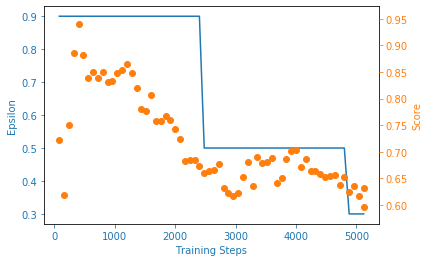

In [14]:
if __name__ == '__main__':
    
    global stop
    stop=False
    ###################################init all parameters############################
    episode_durations = []
    train_result_df=pd.DataFrame(columns=['lr','episode_num','is_random_action','eps','state','action','mape_error','next_s'])
    best_score = -np.inf
    #training mode load_checkpoint=False 
    load_checkpoint = False
    episode_size=int(len(Train)/4)
    episodes_number=30*(len(Train.index)/episode_size) # שיניתי ל 30 במקום 10 לעשות משהו חכם יותר
    init_dict,numeric_param_norm_init_dict,min_max_numeric_field_dict,cat_bool_dict,action_map,num_actions_return=change_numeric_parameter_scal(user_dict)
    episod_num_iter=num_actions_return*4
    early_stopping = EarlyStopping(patience=episod_num_iter*3, verbose=True,delta=0.001) #אם לא השתפר 5 אפסודים נעצור מתחילים לספור אחרי 50% מכל האיטרציות
    #מספר האיטרציות שבערך לוקח לי לעבור על כל הדאטה
    avg_over_iteration=int(len(Train.index)/episode_size)
    counter=0
    learner_model ='RF_Regressor'#'ExtraTreesClassifier'#'DT'#'RF_Classifier'#'RF_Regressor' #'gbdt'#'RF_Regressor'
    
    search= init_dict.copy()
    best_search={}
    train_losses = []
    # to track the validation loss as the model trains
    #valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    #avg_valid_losses = [] 

    ##new for QA episod_num_iter
    
    
    #אחרי כמה איטרציות האיגנט מתחיל ללמוד זה הגודל של הבצ סייי
    #batch_size=100
    batch_size=num_actions_return*4 
    n_actions=num_actions_return


    input_dims=len(search)
    chkpt_dir='/home/ec2-user/SageMaker/TEZA/config changing tests/models/'

    agent = DQNAgent(gamma=0.9, epsilon=0.99, lr=0.1,
                     input_dims=(input_dims,),
                     n_actions=n_actions, mem_size=10000, eps_min=0.001,
                     batch_size=batch_size, replace=n_actions,eps_dec=0.0001, 
                     #location save model models/ if dont have file need to create one!!!!!!!
                     chkpt_dir=chkpt_dir, algo='DQNAgent',
                     env_name='early stoping+change lr+epsilon by num iter',action_space=action_map)
    if load_checkpoint:
        agent.load_models()

    fname = agent.algo + '_' + agent.env_name + '_lr' + str(agent.lr) +'_' \
            + str(episodes_number) + 'Train'
   #######################################creat plot directory###############################
    figure_file = '/home/ec2-user/SageMaker/TEZA/config changing tests/plots/' + fname + '.png'

#for plotting
    n_steps = 0
    scores, eps_history, steps_array = [], [], []
    #for changing lr and epsilon by num iteration+for early stopping ??
    Total_counter=0
    Total_iteration=episodes_number*episod_num_iter
    
    for i in range(int(episodes_number)):
      #Q_list=[]
      stratify_by= None #y_episode
      # clear lists to track next epoch ?????????????? אולי לא כדאי לאפס 
      agent.train_losses = []
      #agent.valid_losses = []
      done_episode = False
      obs = search.copy()
      next_obs = search.copy()
      #counter to check num iteration im apesod  to get done value 
      counter=0
      score = 0

      ##########################  episode  ##########################       

      episode_error=0
      # Create the episode data 
      episode= get_data(episode_size, policy=0, mode='train')
      # Separate the episode data into features and label
      X_episode,y_episode=data_separate(episode)
      
      # Split the data into train and test 
     #new remove? #X_train_main_episode, X_test_main_episode, y_train_episode, y_test_episode = data_split(X_episode,y_episode,stratify_by=stratify_by)
      init_dict=get_init_dict(user_dict)
      # Initiate the error to initial state parameters error
      episode_last_error=Learner(X_episode,y_episode,learner_model=learner_model,parameter_dict=init_dict)
      global min_errors
      min_errors=episode_last_error
      episod_start=timeit.default_timer()
      state_dict=[] #new today clear evey epoc
      
      while not done_episode:
          #state_dict.append(obs)
          #print(state_dict)
          Total_counter=Total_counter+1
          counter=counter+1
          #################try run until gettinn action that chnge dictionary##################
          actions,is_random_choice= agent.choose_action(obs,mood='Train')
          if is_random_choice=='random choice':
            next_obs,action,current_state_for_model_error_checks,next_state_real_val=get_aveilable_action_index_and_val(actions,action_map,obs,min_max_numeric_field_dict,is_random_choice,state_dict)#new today
          if is_random_choice=='not random choice':
            next_obs,action,current_state_for_model_error_checks,next_state_real_val=get_aveilable_action_index_and_val(actions,action_map,obs,min_max_numeric_field_dict,is_random_choice,state_dict)#new today
            #next_obs,action,maxQ,current_state_for_model_error_checks,next_state_real_val=get_aveilable_action_index_and_val(actions,action_map,obs,min_max_numeric_field_dict,is_random_choice,state_dict)#new today
            #print('maxQ',maxQ)
          #change it ??? new   
          state_dict.append(current_state_for_model_error_checks)
          state_dict.append(next_state_real_val)
            
          episode_error=Learner(X_episode,y_episode,learner_model=learner_model,parameter_dict=current_state_for_model_error_checks)
          # Update reward
          episode_reward=episode_last_error-episode_error
          reward=episode_reward

          score += reward
          #agent.lr # לההבין איך לעדכן LR 
        #  agent.q_eval.optimizer.param_groups[0]['lr']
          new_row = {'lr':agent.lr,'episode_num':i,'is_random_action':is_random_choice,'eps':agent.epsilon ,'state':current_state_for_model_error_checks.copy(), 'action':action_map[action] , 'mape_error':episode_error ,'next_s':next_state_real_val}
          #append row to the dataframe.  new_row = {'lr':agent.q_eval.scheduler.get_lr(),'episode_num':i,'is_random_action':is_random_choice,'eps':agent.epsilon ,'state':current_state_for_model_error_checks.copy(), 'action':action_map[action] , 'mape_error':episode_error ,'next_s':next_state_real_val}
          train_result_df = train_result_df.append(new_row, ignore_index=True)
          if min_errors >episode_error:

            min_errors =episode_error
            best_search =current_state_for_model_error_checks.copy() 
     
          if not load_checkpoint:
              agent.store_transition( list(obs.values()), action,
                                    reward, list(next_obs.values()), int(done_episode))
              agent.learn(Total_counter,Total_iteration)
              #new for early stoping
              #if ((agent.memory.mem_cntr >= agent.batch_size) and (agent.epsilon<0.6) and (i>10)) :
              #if ((agent.memory.mem_cntr >= agent.batch_size) and (i>30)) : #50??
              #if (agent.epsilon<=0.01) :
              if (Total_counter>Total_iteration*0.5) :#30!!! Total_iteration Total_counter
                #??i>5 

                train_loss = np.average(agent.train_losses)
                #valid_loss = np.average(agent.valid_losses)
                avg_train_losses.append(train_loss)
                #avg_valid_losses.append(valid_loss)
                early_stopping(train_loss, agent)
                if early_stopping.early_stop :

                  print("Early stopping")
                  Tfname='early stoping on train init weight RF_Regressor temp'
                  #Tfname =  '_lr' + str(agent.lr) +'_'+ str(episodes_number) + '_eps_decay' + str(agent.eps_dec) +'_' + 'episodes_number' + str(episodes_number) +'_'+ 'episod_num_iter' + str(episod_num_iter)+'batch_size'+str(batch_size) 
                  save_path_train = '/home/ec2-user/SageMaker/TEZA/config changing tests/Trials/' + Tfname + '.csv'
                  train_result_df.to_csv(save_path_train)
                  break  

          is_done=((counter==episod_num_iter) or (stop==True)) #done(counter,n_actions,next_obs,obs)or (early_stopping.early_stop and i > 5)
          done_episode=(is_done)
          obs = next_obs.copy()
          episode_last_error=episode_error

          n_steps += 1


#ploy duration not working fix-update episod duration 
          if done_episode:
            episod_end=timeit.default_timer()
            episod_time=episod_end-episod_start
            episode_durations.append(episod_time)
            # print(episode_durations)
            # %matplotlib inline
            # plot_durations()
            # break    



      scores.append(score)
# we want to plote the score as function of number of steps
      steps_array.append(n_steps)
      #נרוץ על מספר איטרציות שבממוצע כל הדאטה שלהם זה הדאטה בכל הדאטה סט
      avg_score = np.mean(scores[-avg_over_iteration:])
      #instead avg look at sum of all scores until now checking if we improvs???
      sum_score = np.sum(scores[:])
      print('episod time',episod_time,'epsilon:',agent.epsilon,'episode: ', i,'score: ', score,'best score %.2f' % best_score,'best_params',best_search,'min_error',min_errors,current_state_for_model_error_checks)
      # early_stopping(valid_loss, agent)#לבדוק מה יש בארלי סטופינק לשמור את ה רשת השניה גם להבין איך
      # if early_stopping.early_stop and agent.epsilon<0.6:
      #       print("Early stopping")
      #       Tfname =  '_lr' + str(agent.lr) +'_'+ str(episodes_number) + '_eps_decay' + str(agent.eps_dec) +'_' + 'episodes_number' + str(episodes_number) +'_'+ 'episod_num_iter' + str(episod_num_iter)+'batch_size'+str(batch_size) 
      #       save_path_train = '/content/drive/My Drive/TEZA/Trials/' + Tfname + '.csv'
      #       train_result_df.to_csv(save_path_train)
      #       break

      if avg_score > best_score:
          best_score = avg_score

#?????????????????????????????????????????????????????only last epsilon of the episod and not all epsilons why???
      eps_history.append(agent.epsilon)
      if ((load_checkpoint and n_steps >= 18000) or (early_stopping.early_stop)):
          break

    #agent.save_models() צריך להוריד כי נישמור רק אם הולידישן השתפר??
    time.sleep(100)
    x = [i+1 for i in range(len(scores))]
    plot_learning_curve(steps_array, scores, eps_history, figure_file)
    #save to drive
    Tfname =  '_lr' + str(agent.lr) +'_'+ str(episodes_number) + '_eps_decay' + str(agent.eps_dec) +'_' + 'episodes_number' + str(episodes_number) +'_'+ 'episod_num_iter' + str(episod_num_iter)+'batch_size'+str(batch_size) 

    save_path_train = '/home/ec2-user/SageMaker/TEZA/config changing tests/Trials/' + Tfname + '.csv'
    train_result_df.to_csv(save_path_train)

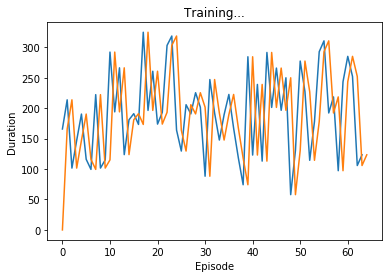

In [15]:
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = T.tensor(episode_durations, dtype=T.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    
    # Take 10 episode averages and plot them too
    if len(durations_t) >= 1:
        means = durations_t.unfold(0, 1, 1).mean(1).view(-1)
        means = T.cat((T.zeros(1), means))
        plt.plot(means.numpy())
        

    plt.pause(0.001)  # pause a bit so that plots are updated

    # if is_ipython:
    #     display.clear_output(wait=True)
    #     display.display(plt.gcf())
        
plot_durations()

In [26]:
sum(episode_durations)/60/60 #hours

3.416391268091716

[]

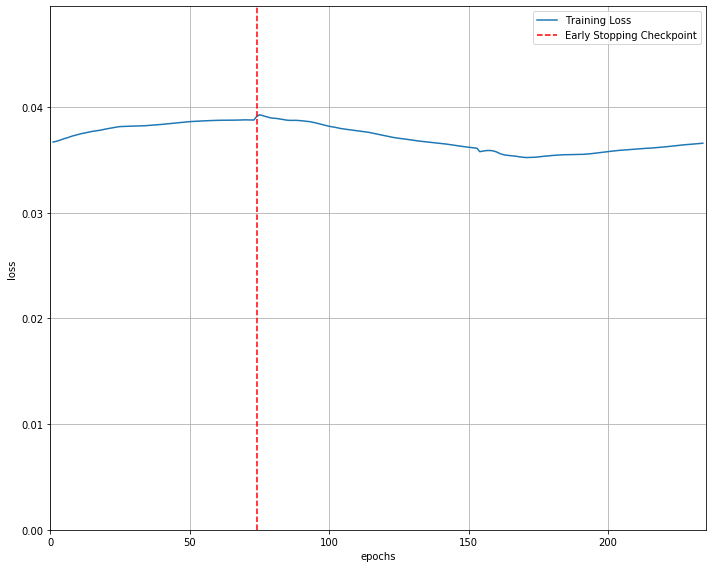

In [16]:
import matplotlib.pyplot as plt
N=episod_num_iter
train_loss=pd.Series(avg_train_losses).rolling(window=N).mean().iloc[N-1:].values
#train_loss=avg_train_losses
#valid_loss=avg_valid_losses
#valid_loss=pd.Series(avg_valid_losses).rolling(window=N).mean().iloc[N-1:].values
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
#plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
#minposs = valid_loss.index(min(valid_loss))+1 
minposs = avg_train_losses.index(min(avg_train_losses))+1 

plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, max (avg_train_losses)) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

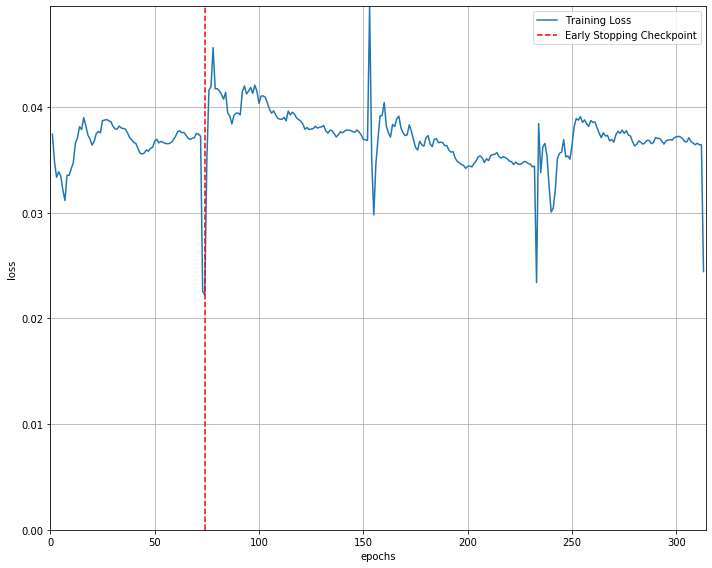

In [17]:
import matplotlib.pyplot as plt
#N=episod_num_iter
train_loss=avg_train_losses
#pd.Series(avg_train_losses).rolling(window=N).mean().iloc[N-1:].values
#train_loss=avg_train_losses
#valid_loss=avg_valid_losses
#valid_loss=pd.Series(avg_valid_losses).rolling(window=N).mean().iloc[N-1:].values
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
#plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
#minposs = valid_loss.index(min(valid_loss))+1 
minposs = avg_train_losses.index(min(avg_train_losses))+1 

plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, max (avg_train_losses)) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [57]:
# data=Train #Test #Train #????test??                                                                 
# load_checkpoint = True
# episodes_number=1000
# batch_size=100
# counter=0
# state_dict=[]
# stop=False
# learner_model ='RF_Regressor' #'ExtraTreesClassifier'#'DT'#'RF_Classifier'#'RF_Regressor'#'gbdt' #'RF_Regressor'
# result_df=pd.DataFrame(columns=['state','next_state','action','Qmax'])

In [40]:
if __name__ == '__main__':

    global stop
    data=Test
    stop=False
    episod_num_iter=40000
    load_checkpoint = True
    learner_model ='RF_Regressor'#'ExtraTreesClassifier'#'DT'#'RF_Classifier'#'RF_Regressor' #'gbdt'#'RF_Regressor'
    ###################################init all parameters############################
    test_result_df=pd.DataFrame(columns=['state','next_state','action','Qmax'])

    init_dict,numeric_param_norm_init_dict,min_max_numeric_field_dict,cat_bool_dict,action_map,num_actions_return=change_numeric_parameter_scal(user_dict)
    search= init_dict.copy()
    best_search={}

    input_dims=len(search)
    chkpt_dir='/home/ec2-user/SageMaker/TEZA/config changing tests/models/'

    agent = DQNAgent(gamma=0.9, epsilon=0, lr=0.1,
                 input_dims=(input_dims,),
                 n_actions=n_actions, mem_size=10000, eps_min=0.001,
                 batch_size=batch_size, replace=n_actions,eps_dec=0.0001, 
                 #location save model models/ if dont have file need to create one!!!!!!!
                 chkpt_dir=chkpt_dir, algo='DQNAgent',
                 env_name='early stoping+change lr+epsilon by num iter',action_space=action_map)
    if load_checkpoint:
        agent.load_models()

    fname = agent.algo + '_' + agent.env_name + '_lr' + str(agent.lr) +'_' \
        + str(episodes_number) + 'Test'
    #######################################creat plot directory###############################
    figure_file = '/home/ec2-user/SageMaker/TEZA/config changing tests/plots/' + fname + '.png'

    #for plotting


    #Q_list=[]
    stratify_by= None #y_episode
    done_episode = False
    obs = search.copy()
    next_obs = search.copy()
    #counter to check num iteration im apesod  to get done value 
    counter=0
    #score = 0

    ##########################  episode  ##########################       
    
    episode= data
    X_episode,y_episode=data_separate(episode)
    init_dict=get_init_dict(user_dict)
    state_dict=[] #new today clear evey epoc

    while not done_episode:

      counter=counter+1
      #################try run until gettinn action that chnge dictionary##################
      actions,is_random_choice= agent.choose_action(obs,mood='Train')
      if is_random_choice=='random choice':
        maxQ,next_obs,action,current_state_for_model_error_checks,next_state_real_val=get_aveilable_action_index_and_val_test(actions,action_map,obs,min_max_numeric_field_dict,is_random_choice,state_dict)#new today
      if is_random_choice=='not random choice':
        maxQ,next_obs,action,current_state_for_model_error_checks,next_state_real_val=get_aveilable_action_index_and_val_test(actions,action_map,obs,min_max_numeric_field_dict,is_random_choice,state_dict)#new today

      state_dict.append(current_state_for_model_error_checks)
      state_dict.append(next_state_real_val)

      new_row = new_row = {'state':current_state_for_model_error_checks.copy(), 'next_state':next_state_real_val.copy() , 'action':action_map[action] ,'Qmax':maxQ}
      print(new_row)
      #append row to the dataframe.  new_row = {'lr':agent.q_eval.scheduler.get_lr(),'episode_num':i,'is_random_action':is_random_choice,'eps':agent.epsilon ,'state':current_state_for_model_error_checks.copy(), 'action':action_map[action] , 'mape_error':episode_error ,'next_s':next_state_real_val}
      test_result_df = test_result_df.append(new_row, ignore_index=True)

      is_done=((counter==episod_num_iter) or (maxQ<0)) #done(counter,n_actions,next_obs,obs)or (early_stopping.early_stop and i > 5)
      done_episode=(is_done)
      obs = next_obs.copy()
      n_steps += 1
        
      if is_done:
        best_param=current_state_for_model_error_checks
        print('best_param',best_param)

    Tfname =  'Test_lr' + str(agent.lr) +'_'+ str(episodes_number) + '_eps_decay' + str(agent.eps_dec) +'_' + 'episodes_number' + str(episodes_number) +'_'+ 'episod_num_iter' + str(episod_num_iter)+'batch_size'+str(batch_size) 

    save_path_train = '/home/ec2-user/SageMaker/TEZA/config changing tests/Trials/' + Tfname + '.csv'
    test_result_df.to_csv(save_path_train)

... loading checkpoint ...
odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'out.weight', 'out.bias'])
... loading checkpoint ...
odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'out.weight', 'out.bias'])
{'state': {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_leaf', -0.01], 'Qmax': 2.693056106567383}
{'state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1000, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 50, 'min_samples_leaf': 2, 'min

{'state': {'max_depth': 44, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 45, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 46, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 46, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 45, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 49, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1119, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1119, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 49, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1119, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1119, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 48, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1119, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1119, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1199, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1199, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1199, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1218, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1218, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1218, 'bootstrap': False, 'max_features': 'auto'}, 'action

{'state': {'max_depth': 46, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 48, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 48, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1258, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1258, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1258, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1258, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 46, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1258, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1258, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 42, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 43, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 44, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 46, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1318, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1318, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 45, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1318, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1318, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 44, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1318, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_es

{'state': {'max_depth': 46, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 48, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 49, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 48, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 48, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 49, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 48, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 44, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 43, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 42, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 41, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 48, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 49, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 44, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 45, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 46, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 49, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 46, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 46, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 45, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 41, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 41, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 41, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 41, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 41, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'action

{'state': {'max_depth': 49, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 45, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 46, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 49, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 48, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 49, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 48, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 44, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 43, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 42, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 41, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 46, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 48, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 43, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 42, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 41, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 41, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 41, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_es

{'state': {'max_depth': 47, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 46, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 45, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 47, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 49, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 49, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 49, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 49, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 47, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 46, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 45, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 42, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 43, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 44, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 47, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 46, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 40, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 41, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 41, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 42, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 42, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 43, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 44, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 44, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', -0.1], 'Qmax': 2.372953176498413}
{'state': {'max_depth': 44, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 44, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'action'

{'state': {'max_depth': 46, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 47, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 49, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 49, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 47, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 49, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 49, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 47, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 43, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 42, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 42, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['mi

{'state': {'max_depth': 41, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 42, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 43, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 45, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 44, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 44, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['mi

{'state': {'max_depth': 49, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 49, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 49, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 47, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 46, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 43, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 42, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 42, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['mi

{'state': {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 49, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 43, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 42, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 41, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 41, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 40, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 46, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 45, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 44, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 49, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 49, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 49, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 41, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 40, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 40, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 40, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 40, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 40, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 40, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 41, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 41, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 42, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 46, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 47, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 48, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 48, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 47, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 46, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 47, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 48, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 49, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 49, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 49, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 48, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 48, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 48, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 49, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_sa

{'state': {'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 49, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 48, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 45, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 44, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 43, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 42, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 41, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 41, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 41, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 41, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 41, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['mi

{'state': {'max_depth': 47, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 47, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 46, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 46, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 46, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 47, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 50, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', -0.1], 'Qmax': 2.372953176498413}
{'state': {'max_depth': 50, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 50, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action'

{'state': {'max_depth': 44, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 45, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 46, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 48, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 49, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 50, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_sa

{'state': {'max_depth': 47, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 46, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 45, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 45, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 46, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 47, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 44, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 45, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 45, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 44, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 45, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 46, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 44, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 45, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 46, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 46, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 45, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 45, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['mi

{'state': {'max_depth': 49, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 50, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 50, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 45, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 44, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 44, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 45, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 44, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 43, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 42, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 41, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 41, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 41, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 41, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 41, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['mi

{'state': {'max_depth': 40, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 40, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 40, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 40, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', -0.1], 'Qmax': 2.372953176498413}
{'state': {'max_depth': 40, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 41, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action'

{'state': {'max_depth': 45, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 44, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 43, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 45, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 46, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 47, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 50, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 49, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 48, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 48, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 48, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 47, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 49, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 50, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 50, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 49, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 48, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 47, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 44, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 43, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 42, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_es

{'state': {'max_depth': 47, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 48, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 49, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 45, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 45, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 44, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 45, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 46, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 47, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_sa

{'state': {'max_depth': 45, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 46, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 47, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 46, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 45, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 45, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['mi

{'state': {'max_depth': 48, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 49, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 50, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_sa

{'state': {'max_depth': 45, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 45, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 44, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 47, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 46, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 45, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 45, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 44, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 43, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 42, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 43, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 44, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 40, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 40, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 40, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 41, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 41, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 46, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 46, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 45, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 45, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 45, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 46, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 50, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 50, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 49, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 45, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 44, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 44, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 46, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 45, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 44, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 44, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 43, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 42, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 41, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 42, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 43, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 44, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 50, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 49, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 48, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 43, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 42, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 41, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 41, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 40, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 47, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 46, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 45, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 48, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 47, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 46, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 46, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 45, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 44, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 42, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 42, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 42, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'action

{'state': {'max_depth': 49, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 50, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 50, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 46, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 47, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 48, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 50, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 49, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 48, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_es

{'state': {'max_depth': 44, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 44, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 43, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 46, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 45, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 44, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 44, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 43, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 42, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 41, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 42, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 43, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 44, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 50, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 50, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 49, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 46, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 47, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 48, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 50, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 49, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 48, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_es

{'state': {'max_depth': 45, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 44, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 44, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 47, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 46, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 45, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 46, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 45, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 44, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 43, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 42, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 42, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['mi

{'state': {'max_depth': 47, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 48, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 49, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 45, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 45, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 45, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'action

{'state': {'max_depth': 48, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 49, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 50, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_sa

{'state': {'max_depth': 46, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 46, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 45, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 50, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 49, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 48, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 49, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 48, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 47, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 46, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 45, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 44, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 43, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 44, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 45, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 49, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 48, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 47, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 49, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 48, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 47, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_es

{'state': {'max_depth': 42, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 41, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 41, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 41, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 41, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 40, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 44, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 43, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 43, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 42, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 42, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 41, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 47, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 48, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 49, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['

{'state': {'max_depth': 48, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 47, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 47, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'action'

{'state': {'max_depth': 44, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 45, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 46, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['

{'state': {'max_depth': 45, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 46, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 47, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 47, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['

{'state': {'max_depth': 47, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 46, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 46, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 45, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 45, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 44, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 50, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 49, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 49, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 48, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 48, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 68, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 68, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 68, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 67, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 67, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 66, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'ac

{'state': {'max_depth': 62, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 62, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 62, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 63, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 63, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 64, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'act

{'state': {'max_depth': 67, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 68, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 68, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 68, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 68, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 67, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'act

{'state': {'max_depth': 62, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 61, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 61, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 60, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 60, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 59, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 64, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 64, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 64, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 64, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 64, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 65, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, '

{'state': {'max_depth': 68, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 68, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 68, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 68, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 68, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 67, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, '

{'state': {'max_depth': 58, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 59, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 59, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 60, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 60, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 61, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['

{'state': {'max_depth': 61, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 62, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 62, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 63, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 63, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 64, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['

{'state': {'max_depth': 67, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 66, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 66, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 65, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 65, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 64, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 58, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 58, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', -0.1], 'Qmax': 2.372953176498413}
{'state': {'max_depth': 58, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 59, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 59, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 60, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 68, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 67, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 67, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 66, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 66, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 65, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 64, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 65, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 65, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 66, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 66, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 67, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['

{'state': {'max_depth': 67, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 67, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 67, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 67, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 67, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 68, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'auto'}, '

{'state': {'max_depth': 60, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 59, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 59, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 58, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 58, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 58, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 64, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 65, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 65, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 66, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 66, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 66, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['

{'state': {'max_depth': 73, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 74, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 74, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 75, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 75, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 76, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['

{'state': {'max_depth': 73, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 72, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 72, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 71, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 71, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 71, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 76, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 75, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 75, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 75, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 75, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 75, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'action'

{'state': {'max_depth': 70, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 69, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 69, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 69, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 69, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 69, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'action'

{'state': {'max_depth': 76, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 75, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 75, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 74, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 74, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 73, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 76, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 76, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 76, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 76, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 75, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'auto'}, 'ac

{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'auto'}, 'ac

{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'auto'}, 'ac

{'state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'ac

{'state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'auto'}, 'act

{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['

{'state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['

{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'auto'}, 'act

{'state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['

{'state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['

{'state': {'max_depth': 76, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['

{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'ac

{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1139, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'auto'}, '

{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 76, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 76, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 76, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1199, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1218, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'auto'}, '

{'state': {'max_depth': 76, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1278, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 76, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 76, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 76, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 76, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'auto'}, '

{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1139, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1139, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1139, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1139, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1139, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1139, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['

{'state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'auto'}, 'ac

{'state': {'max_depth': 76, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1119, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 76, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1139, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 76, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1139, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1139, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1139, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1139, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1059, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1059, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1059, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1059, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1059, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1059, 'bootstrap': False, 'max_features': 'auto'}, 'act

{'state': {'max_depth': 76, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 76, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 920, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 76, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 920, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 76, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 721, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', -0.1], 'Qmax': 2.372953176498413}
{'state': {'max_depth': 76, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 721, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 721, 'bootstrap': False, 'max_features': 'auto'}, 'action'

{'state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 761, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_es

{'state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 860, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 860, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 900, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 900, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 900, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 900, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 900, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 900, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 522, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 522, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 522, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 522, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 522, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 522, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_sa

{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 442, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 462, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 462, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 462, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 462, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 462, 'bootstrap': False, 'max_features': 'auto'}, 'action

{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 303, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 442, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 442, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 482, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 482, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 482, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 482, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 482, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 482, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': 

{'state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 522, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 522, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 522, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 522, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 522, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 522, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_de

{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_sa

{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 701, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 701, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 701, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 701, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 701, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 701, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': 

{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 900, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 900, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 900, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 900, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 900, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 900, 'bootstrap': False, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 940, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 940, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 940, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 940, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 940, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 940, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_de

{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': 

{'state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'sqrt'}, 'act

{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1199, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1199, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1199, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1199, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1199, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1199, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1278, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'sqrt'}, '

{'state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'sqrt'}, 'ac

{'state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'sqrt'}, 'act

{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, '

{'state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'sqrt'}, '

{'state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'sqrt'}, '

{'state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': 

{'state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'ac

{'state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 82, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 83, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 80, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 81, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 84, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'sqrt'}, 'ac

{'state': {'max_depth': 79, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 78, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 77, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'ac

{'state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'sqrt'}, 'action'

{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': 

{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': 

{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': 

{'state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'sqrt'}, 'action'

{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'ac

{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': 

{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1258, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1258, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1258, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1258, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1258, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1258, 'bootstrap': False, 'max_features': 'sqrt'}, 'ac

{'state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'sqrt'}, 'act

{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 960, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'sqrt'}, 'action

{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': 

{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': 

{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 781, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 781, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 781, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 781, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 781, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 820, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 840, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 840, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 840, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 840, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 840, 'bootstrap': False, 'max_features': 'sqrt'}, 'action

{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 880, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 880, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 880, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 880, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 880, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 880, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_de

{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 621, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 621, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 621, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 621, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 621, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 621, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 482, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 482, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 482, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 482, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 482, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 482, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_sa

{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 323, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 323, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 323, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 323, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 323, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 323, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_de

{'state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_es

{'state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 403, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_es

{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_de

{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 502, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 502, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 502, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 502, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 502, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 502, 'bootstrap': False, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 562, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 562, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 562, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 562, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 562, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'action

{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 741, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': False, 'max_features': 'sqrt'}, 'actio

{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 840, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 840, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 840, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 840, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 840, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 840, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_d

{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 920, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 940, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 940, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 940, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 940, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 940, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max

{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1039, 'bootstrap': False, 'max_features': 'sqr

{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'sqrt'}, 

{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1199, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1199, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1199, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1199, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1199, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1199, 'bootstrap': False, 'max_features': 'sqrt'}, 'act

{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1278, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1278, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1278, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'sqrt'}, 'ac

{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 

{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'sqrt'}, 'ac

{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'sqrt'}, 'ac

{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'sqrt'}, 

{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'ac

{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': True, 'max_features': 'sqrt'}, 'actio

{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max

{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_d

{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': 

{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'sqrt'}, 'actio

{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['mi

{'state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max

{'state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 

{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1915, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1915, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1915, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', -0.1], 'Qmax': 2.372953176498413}
{'state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_sampl

{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['m

{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samp

{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 

{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth

{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['ma

{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1318, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_sampl

{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1199, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1199, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1199, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1199, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1199, 'bootstrap': True, 'max_features': 'sqrt'}, 'action'

{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1238, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1238, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1238, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1238, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1238, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1238, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1298, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1298, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1298, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1099, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', -0.1], 'Qmax': 2.372953176498413}
{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1099, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_sampl

{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1179, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1179, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1179, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1179, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1179, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1019, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1019, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1019, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1019, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1019, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1019, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1099, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1099, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1099, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1099, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1099, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1119, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimato

{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 940, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 960, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 960, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 960, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 960, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 960, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_dep

{'state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 820, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 820, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 820, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 820, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 820, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 820, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01],

{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 880, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0

{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 741, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 741, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 741, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 741, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_sampl

{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 582, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 582, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 582, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 582, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 582, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 582, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.

{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_dept

{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 522, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 522, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 522, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 522, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 522, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 522, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01]

{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 383, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 383, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 383, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 403, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_est

{'state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01],

{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 502, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 502, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 502, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 502, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 502, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 502, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth'

{'state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth'

{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 204, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 204, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 204, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 204, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 204, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 204, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.

{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 283, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 283, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 283, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 303, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 303, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 303, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_dep

{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 144, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 144, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 144, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 144, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 144, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 144, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01]

{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 164, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 164, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 164, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 164, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 164, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 164, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max

{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 204, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 223, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 223, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 223, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 223, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 223, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['m

{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 283, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 283, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 283, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 303, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_sam

{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 343, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['m

{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 403, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 403, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 403, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 403, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 403, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 422, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimato

{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 482, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 482, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 482, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 502, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 502, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 502, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['m

{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth',

{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 621, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 621, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 621, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 621, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 621, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 641, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': [

{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 

{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 721, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 741, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 741, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 741, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['m

{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 820, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 820, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 820, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 820, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 820, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 820, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 

{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 860, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 940, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 960, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 960, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 960, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 960, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 960, 'bootstrap': True, 'max_features': 'sqrt'}, 'action'

{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1000, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min

{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1059, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1059, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1059, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1059, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1059, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1059, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_d

{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1139, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1139, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1139, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1139, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1139, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1139, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_de

{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max

{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1258, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1278, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1278, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': True, 'max_features': 'sqrt'}, 'a

{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_d

{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1358, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': True, 'max_features': 'sqrt'}, 'action

{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_de

{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'sqrt'}, 'actio

{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': True, 'max_features': 'sqrt'}, 'acti

{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': 

{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'sqrt'}, 'act

{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_de

{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'sqrt'}, 'actio

{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'sqrt'}, '

{'state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_de

{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['mi

{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max

{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min

{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'action

{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['mi

{'state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['mi

{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'actio

{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_d

{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max

{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'sqrt'}, 'a

{'state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_de

{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['mi

{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'sqrt'}, 'action

{'state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_de

{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimato

{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1915, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1915, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1915, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max

{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth

{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'sqrt'}, 'action

{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1756, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 

{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimato

{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1437, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1437, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min

{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1557, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1557, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_sampl

{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['m

{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1238, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1238, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1238, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1258, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1258, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1258, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samp

{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1318, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1318, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1318, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1338, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_e

{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 

{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1000, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_sampl

{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1059, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1059, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1059, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1059, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1059, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1059, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth'

{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1099, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1099, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1099, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1119, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1119, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1119, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samp

{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 980, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 980, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 980, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_dept

{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 820, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 820, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 820, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 820, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 820, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 820, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth'

{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 880, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 880, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 880, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 880, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 880, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 880, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_spl

{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 940, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 960, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 960, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 960, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 960, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 960, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_dep

{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 781, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 781, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 781, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 801, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 801, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_sp

{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 641, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 641, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 641, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 641, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 641, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimat

{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 701, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 701, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 701, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 701, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 701, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_dep

{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 542, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth

{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 602, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 602, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 602, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 621, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 621, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 621, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_sp

{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 442, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 442, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 442, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 442, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 442, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 442, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.

{'state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 522, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 522, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 522, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 522, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 522, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 522, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_sampl

{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.

{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 223, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 223, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 223, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 223, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 223, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 243, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_est

{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 263, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 283, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 283, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 283, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 283, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 283, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_dep

{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 323, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 323, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 323, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 323, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 323, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 323, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_spl

{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 184, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 184, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 184, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 184, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 184, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 184, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth

{'state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 24, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 24, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 24, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 24, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 24, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 24, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax

{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 84, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 84, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 84, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 84, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 84, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 104, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimator

{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 164, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 164, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 164, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 164, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 164, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 164, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01],

{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 10, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['bootstrap', False], 'Qmax': 2.3509645462036133}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 204, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 204, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 204, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 204, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 204, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 204, 'bootstrap': False, 'max_features': 'sqrt'}, 'actio

{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 243, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 243, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 243, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 243, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 243, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 243, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max

{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 323, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 323, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 323, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 323, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 323, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'acti

{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 403, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_es

{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 462, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 482, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 482, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 482, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 482, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 482, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max

{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_leaf', -0.1], 'Qmax': 2.3274385929107666}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'sqrt'}, 'action'

{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 602, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 602, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 602, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 621, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 621, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 621, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['m

{'state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 701, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 721, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 721, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 721, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 721, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 721, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['m

{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 781, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 781, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 781, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 781, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 781, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 781, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 820, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 820, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 820, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 820, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 820, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 820, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth'

{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 900, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 900, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 900, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 920, 'bootstrap': False, 'max_features': 'sqrt'}, 'action

{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 940, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 960, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 960, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 960, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 960, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 960, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['m

{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1000, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min

{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1119, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1119, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1119, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1119, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1119, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1119, 'bootstrap': False, 'max_features': 'sqrt'}, 'actio

{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['mi

{'state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1278, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1278, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1298, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_e

{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_d

{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'sqrt'}, 'action

{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['mi

{'state': {'max_depth': 96, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_de

{'state': {'max_depth': 97, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_d

{'state': {'max_depth': 100, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'sqrt'}, 'actio

{'state': {'max_depth': 99, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 98, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_es

{'state': {'max_depth': 100, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 100, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'sqrt'}, '

{'state': {'max_depth': 94, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 94, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 94, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': False, 'max_features': 'sqrt'}, 'action

{'state': {'max_depth': 97, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_d

{'state': {'max_depth': 99, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 99, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 96, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_sa

{'state': {'max_depth': 100, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1278, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', -0.1], 'Qmax': 2.372953176498413}
{'state': {'max_depth': 100, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1278, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 100, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': False, 'max_features': 'sqrt'}, 'ac

{'state': {'max_depth': 94, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1318, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 94, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1318, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 94, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': False, 'max_features': 'sqrt'}, 'action

{'state': {'max_depth': 97, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_d

{'state': {'max_depth': 99, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 98, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 95, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 95, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 96, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': 

{'state': {'max_depth': 89, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 90, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_de

{'state': {'max_depth': 92, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 92, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 93, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': 

{'state': {'max_depth': 92, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 93, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 93, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': 

{'state': {'max_depth': 86, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 86, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 86, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'sqrt'}, 'action

{'state': {'max_depth': 92, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 90, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 90, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 90, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['mi

{'state': {'max_depth': 90, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 89, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 89, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 86, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 85, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 85, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1835, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['mi

{'state': {'max_depth': 93, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': 

{'state': {'max_depth': 89, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 90, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_de

{'state': {'max_depth': 92, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['mi

{'state': {'max_depth': 89, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 88, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 88, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': False, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_de

{'state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_de

{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1915, 'bootstrap': False, 'max_features': 'sqrt'}, 'action

{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', -0.1], 'Qmax': 2.372953176498413}
{'state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'sqrt'}, 'action'

{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': False, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_de

{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', -0.1], 'Qmax': 2.372953176498413}
{'state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min

{'state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': 

{'state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['mi

{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': 

{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_sa

{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1199, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_es

{'state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_de

{'state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1298, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1318, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1318, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['mi

{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1139, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1139, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1139, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1139, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1139, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1139, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': 

{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1000, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_

{'state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1039, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1039, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1039, 'bootstrap': False, 'max_features': 'sqrt'}, 'action

{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1059, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1059, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1059, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1059, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1059, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1059, 'bootstrap': False, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_sa

{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 721, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 721, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 721, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 721, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 721, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 721, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 761, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 761, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 761, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 761, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 761, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 761, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min

{'state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 

{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 820, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 820, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 820, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 820, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 820, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 840, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimato

{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth'

{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 701, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 701, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 701, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 701, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 701, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 701, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 

{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min

{'state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 562, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 562, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 562, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samp

{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 602, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 602, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 602, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 602, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 602, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 602, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth'

{'state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 

{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 303, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 303, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 303, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max

{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 323, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 323, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 323, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 323, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 323, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 323, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 363, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samp

{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth'

{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 

{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 64, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 64, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 64, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 64, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 64, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 64, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_sampl

{'state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 84, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 84, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 84, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 84, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 84, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 104, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 

{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 124, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 124, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 124, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 124, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 124, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 124, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max

{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 164, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 164, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 164, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 164, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 164, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 164, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 223, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 223, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 223, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 223, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 223, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 223, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 44, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', -0.1], 'Qmax': 2.372953176498413}
{'state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_dept

{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 104, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 104, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 104, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 104, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 104, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 104, 'bootstrap': False, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 144, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 144, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 144, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 144, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 144, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 144, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_de

{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 164, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 164, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 164, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 164, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 164, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 164, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_sampl

{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 223, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 243, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 243, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 243, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 243, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 243, 'bootstrap': False, 'max_features': 'sqrt'}, 'action'

{'state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 283, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 283, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 283, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 283, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 283, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 283, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': [

{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 403, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 403, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 403, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samp

{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 442, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 462, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 462, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 462, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 462, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 462, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 502, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 502, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 502, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 502, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 502, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 502, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth'

{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth'

{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_leaf', -0.1], 'Qmax': 2.3274385929107666}
{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max

{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 184, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 184, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 184, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 184, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 184, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 184, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max

{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 223, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 223, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 223, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 223, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 223, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 223, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 

{'state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 263, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 263, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 263, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 263, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 263, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 263, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 

{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 323, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 343, 'bootstrap': False, 'max_features': 'sqrt'}, 'action'

{'state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimato

{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 403, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 403, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 403, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 403, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 403, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 422, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimato

{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 462, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 462, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 462, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 482, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 482, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 482, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_sam

{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 522, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 522, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 522, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 522, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 522, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 522, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth',

{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 641, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'sqrt'}, 'action'

{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 681, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 681, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 681, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 681, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 681, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 681, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth'

{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 721, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 721, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 721, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 721, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 721, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 721, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth

{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 781, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 781, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 781, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 781, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 781, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 781, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 840, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 840, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 840, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 840, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 840, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 840, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth',

{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 880, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 880, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 880, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 880, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 880, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['m

{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 920, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 920, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 920, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['

{'state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 980, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max

{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'sqrt'}, 'actio

{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1079, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['mi

{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1139, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 95, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max

{'state': {'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 98, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1218, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1218, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1218, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1238, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['mi

{'state': {'max_depth': 93, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1318, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1318, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': 

{'state': {'max_depth': 92, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 90, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 89, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 88, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 88, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['mi

{'state': {'max_depth': 92, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'sqrt'}, 'action': ['mi

{'state': {'max_depth': 86, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1517, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1517, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 86, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1517, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1517, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 85, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1517, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1517, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min

{'state': {'max_depth': 92, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1557, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1557, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1557, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1557, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 90, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1557, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1557, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth'

{'state': {'max_depth': 89, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 90, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 

{'state': {'max_depth': 90, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 90, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 91, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 93, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 94, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_

{'state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 

{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_

{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max

{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max

{'state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1895, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_e

{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1915, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1915, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1915, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1915, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1915, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1915, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth'

{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_

{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 

{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_es

{'state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1835, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max

{'state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1875, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_de

{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1895, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': True, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1955, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': 

{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1597, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1597, 'bootstrap': True, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_es

{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1676, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': True, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_de

{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_es

{'state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': True, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1437, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1437, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1437, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1437, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1437, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1437, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_sa

{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_sa

{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1517, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': True, 'max_features': 'sqrt'}, 'action

{'state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1358, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1358, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1358, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1358, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1358, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1358, 'bootstrap': True, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1179, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1179, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1179, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1179, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1179, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': 

{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1199, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1199, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1199, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1199, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1199, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1199, 'bootstrap': True, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1258, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1258, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1258, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1258, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1258, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1258, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_de

{'state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1318, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1318, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1318, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1318, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1318, 'bootstrap': True, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 940, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 940, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 940, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 940, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 940, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 940, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth'

{'state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_de

{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1059, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_es

{'state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1099, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1099, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1099, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': True, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1119, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1119, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1119, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', -0.1], 'Qmax': 2.372953176498413}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 920, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_sa

{'state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 721, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 721, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 721, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 721, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 721, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 721, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 

{'state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 761, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 761, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 761, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samp

{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 801, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 840, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 840, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 840, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 840, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 840, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 840, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min

{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 880, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 880, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 880, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 880, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 880, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 880, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth'

{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 701, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 701, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 701, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 701, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 701, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 701, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth'

{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 542, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 542, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 542, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 542, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 542, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 542, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth'

{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 621, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 621, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 621, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 621, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 621, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 621, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min

{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 641, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 641, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 641, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 641, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 641, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 641, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_

{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max

{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 303, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 303, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 303, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_

{'state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max

{'state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 383, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth'

{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 422, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 422, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 422, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 422, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 422, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 422, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth'

{'state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 462, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 462, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 462, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 462, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 462, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 462, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 

{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 84, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 84, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 84, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 84, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 84, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 84, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01],

{'state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 144, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 144, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 144, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 164, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 164, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 164, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['m

{'state': {'max_depth': 89, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 184, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 184, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 184, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 184, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 184, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 184, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 

{'state': {'max_depth': 93, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 223, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 223, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 223, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 223, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 223, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 223, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth'

{'state': {'max_depth': 92, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 10, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 10, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_leaf', -0.1], 'Qmax': 2.3274385929107666}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 10, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 10, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 10, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 10, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_dept

{'state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 84, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 84, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 84, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 84, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 84, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 84, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax

{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 104, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 104, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 104, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 104, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 104, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 104, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split'

{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 144, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 144, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 144, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 144, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 144, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 144, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.0

{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 204, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 204, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 204, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 223, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 223, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 223, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_sp

{'state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 283, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 283, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 283, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 283, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 283, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 283, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01],

{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.0

{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 343, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 363, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_dep

{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 442, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 442, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 442, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 442, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth

{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 462, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 462, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 462, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 462, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 462, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 462, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.0

{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 502, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 502, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 502, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 502, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 502, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 502, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01],

{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 542, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 542, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 542, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 542, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 542, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth

{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 602, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 602, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 602, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 602, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 602, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 602, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth

{'state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 661, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_dep

{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 701, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 701, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 701, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 701, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 701, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 701, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split'

{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 761, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0

{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 840, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 840, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 840, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 840, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 840, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 840, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_sampl

{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.0

{'state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 900, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 900, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 900, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 900, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 900, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 900, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01],

{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 920, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth

{'state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 960, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 980, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 980, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_dep

{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1019, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1039, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1039, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1039, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['m

{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1079, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1079, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1079, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1079, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1079, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1079, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth'

{'state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1119, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1119, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1119, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1119, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1119, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1139, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimato

{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1199, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1199, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1199, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1199, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1199, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1218, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_e

{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1258, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1258, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1258, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1258, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1258, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1258, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max

{'state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1298, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 

{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1338, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max

{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1398, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 93, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max

{'state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1457, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1457, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['m

{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 

{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 90, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 89, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1557, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimato

{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 92, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 91, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min

{'state': {'max_depth': 87, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 86, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1676, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimato

{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': 

{'state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 88, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1815, 'bootstrap': True, 'max_features': 'sqrt'}, 'action':

{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1995, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', -0.1], 'Qmax': 2.372953176498413}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 86, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 87, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': True, 'max_features': 'sqrt'}, 'action'

{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['n_estimators', -0.1], 'Qmax': 2.372953176498413}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': True, 'max_features': 'sqrt'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': True, 'max_features': 'sqrt'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1378, 'bootstrap': True, 'max_features': 'sqrt'}, 'action'

{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1457, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1457, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1457, 'bootstrap': True, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1557, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1577, 'bootstrap': True, 'max_features': 'auto'}, 'action

{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1815, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['n_es

{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1895, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1895, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1895, 'bootstrap': True, 'max_features': 'auto'}, 'action

{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 2000, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': True, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1855, 'bootstrap': False, 'max_features': 'auto'}, 'ac

{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': False, 'max_features': 'auto'}, 

{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1935, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1955, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1796, 'bootstrap': False, 'max_features': 'auto'}, 'ac

{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1636, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1656, 'bootstrap': False, 'max_features': 'auto'}, 'action'

{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1736, 'bootstrap': False, 'max_features': 'auto'}, 'ac

{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1616, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', -0.1], 'Qmax': 2.372953176498413}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': False, 'max_features': 'auto'}, 'a

{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1457, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1517, 'bootstrap': False, 'max_features': 'auto'}, 

{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1358, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1378, 'bootstrap': False, 'max_features': 'auto'}, 

{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1437, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['

{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1258, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1258, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1258, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1278, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1278, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': False, 'max_features': 'auto'}, 'action'

{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1338, 'bootstrap': False, 'max_features': 'auto'}, 'ac

{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': False, 'max_features': 'auto'}, 

{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1039, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1039, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1059, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1059, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1059, 'bootstrap': False, 'max_features': 'aut

{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': False, 'max_features': 'auto'}, 'action': [

{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': False, 'max_features': 'auto'}, 'action': [

{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1019, 'bootstrap': False, 'max_features': 'auto'}, 'ac

{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 860, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 880, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_es

{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 940, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 940, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 940, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 940, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 940, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 960, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': False, 'max_features': 'auto'}, 'action': 

{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 661, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 701, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 701, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 701, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 701, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 701, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 701, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 761, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 562, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', -0.1], 'Qmax': 2.372953176498413}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 562, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 562, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 562, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 562, 'bootstrap': False, 'max_features': 'auto'}, 'action'

{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 621, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 641, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 641, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 641, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 641, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 641, 'bootstrap': False, 'max_features': 'auto'}, 'action

{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 462, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 462, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 462, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 482, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 482, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 482, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['mi

{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 542, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 562, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 562, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 562, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 562, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 562, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max

{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 403, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 403, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 403, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 403, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 403, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 403, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 263, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 263, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 263, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 263, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 263, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 263, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 303, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max

{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 363, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 363, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 363, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 363, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 363, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 363, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_d

{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 204, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 223, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 223, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 223, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 223, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 223, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max

{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 64, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 64, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 64, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 64, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 64, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 64, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 144, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 144, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 144, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 144, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 144, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 144, 'bootstrap': False, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 10, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['

{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 204, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 204, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 204, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 223, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 223, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 223, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min_sam

{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 263, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 263, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 263, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 283, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 283, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 283, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min_samp

{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 323, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 323, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 323, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 323, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 323, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 323, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['

{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 403, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 403, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 403, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 403, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 403, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 403, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min

{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 442, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 442, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 442, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 442, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 442, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 442, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth'

{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 502, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 502, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 502, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 502, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 502, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 502, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['

{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 582, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', 

{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 621, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 621, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 621, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 621, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 621, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 621, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min_sampl

{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 681, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 701, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 701, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 701, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 701, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 701, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['

{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 741, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 761, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 761, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 761, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min_samp

{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 801, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 801, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 801, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 801, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['

{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 880, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 880, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 880, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 880, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 880, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 880, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min

{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 920, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth

{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 980, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 980, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min_sampl

{'state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1059, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1059, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1059, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1059, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1059, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1059, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1099, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_d

{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1159, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1159, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1159, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1159, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1159, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1179, 'bootstrap': True, 'max_features': 'auto'}, 'actio

{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1218, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1218, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1218, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1218, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1218, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1218, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_

{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1278, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_de

{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1358, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1358, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 99, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1358, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1358, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1358, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1358, 'bootstrap': True, 'max_features': 'auto'}, 'action':

{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1398, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1417, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1417, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['mi

{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1477, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1477, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1497, 'bootstrap': True, 'max_features': 'auto'}, 'action': [

{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1517, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1537, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1537, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['m

{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1577, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth

{'state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1656, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min_samples_split', -0.01], 'Qmax': 2.442584753036499}
{'state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1656, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 94, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1656, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min

{'state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1696, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 95, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1716, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min_samp

{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1756, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['n_estimators', 0.01], 'Qmax': 2.3789286613464355}
{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1776, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['m

{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1835, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth

{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1875, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1895, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['n_estimato

{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 100, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', -0.01], 'Qmax': 2.4390339851379395}
{'state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['

{'state': {'max_depth': 96, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 98, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': True, 'max_features': 'auto'}, 'next_state': {'max_depth': 99, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 2000, 'bootstrap': True, 'max_features': 'auto'}, 'action': ['max_depth', 

{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['min_samples_split', 0.01], 'Qmax': 2.4488160610198975}
{'state': {'max_depth': 96, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['max_depth', 0.01], 'Qmax': 2.4443857669830322}
{'state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 97, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}, 'act

In [28]:
(maxQ<0)

True

In [66]:
# data=Train #Train #????test??                                                                 
# load_checkpoint = True
# episodes_number=1000
# batch_size=100
# counter=0
# state_dict=[]
# stop=False
# learner_model ='RF_Regressor' #'ExtraTreesClassifier'#'DT'#'RF_Classifier'#'RF_Regressor'#'gbdt' #'RF_Regressor'
# result_df=pd.DataFrame(columns=['state','next_state','action','Qmax'])
# init_dict,numeric_param_norm_init_dict,min_max_numeric_field_dict,cat_bool_dict,action_map,num_actions_return=change_numeric_parameter_scal(user_dict)

# search= init_dict.copy()

# n_actions=num_actions_return
# input_dims=len(search)
# chkpt_dir='/home/ec2-user/SageMaker/TEZA/config changing tests/models/'

# agent = DQNAgent(gamma=0.9, epsilon=0, lr=0.1,
#                      input_dims=(input_dims,),
#                      n_actions=n_actions, mem_size=10000, eps_min=0.001,
#                      batch_size=batch_size, replace=n_actions,eps_dec=0.0001, 
#                      #location save model models/ if dont have file need to create one!!!!!!!
#                      chkpt_dir=chkpt_dir, algo='DQNAgent',
#                      env_name='early stoping+change lr+epsilon by num iter',action_space=action_map)
    


# if load_checkpoint:
#     agent.load_models()

# fname = agent.algo + '_' + agent.env_name + '_lr' + str(agent.lr) +'_' \
#         + str(episodes_number) + 'Test'

# figure_file = '/home/ec2-user/SageMaker/TEZA/config changing tests/plots/' + fname + '.png'

# n_steps = 0
# done_episode = False
# obs = search.copy()
# next_obs = search.copy()
  
# stratify_by=None
# episode= data
# X_episode,y_episode=data_separate(episode)
# # Split the data into train and test 
# X_train_main_episode, X_test_main_episode, y_train_episode, y_test_episode = data_split(X_episode,y_episode,stratify_by=stratify_by)
# init_dict=get_init_dict(user_dict)
# #Q_list=[]
# #is_repeted_3_iterations=False
# best_params={}

# while not done_episode:
#     #state_dict.append(obs)

#     counter=counter+1
#     actions,is_random_choice= agent.choose_action(obs,mood='Test')
#     maxQ,next_state,action,current_state_for_model_error_checks,next_state_real_val=get_aveilable_action_index_and_val_test(actions,action_map,obs,min_max_numeric_field_dict,is_random_choice,state_dict)#new today
#     #add states
#     state_dict.append(current_state_for_model_error_checks)
#     state_dict.append(next_state_real_val)
    
#     new_row = {'state':current_state_for_model_error_checks.copy(), 'next_state':next_state_real_val.copy() , 'action':action_map[action] ,'Qmax':maxQ}
#     print(new_row)
# #append row to the dataframe
#     result_df = result_df.append(new_row, ignore_index=True)
    
#     #if max Q is negativ or we run more then 100 iteration we can stope and return param dict or want to change to same value from 100 to 90 but cant cause 100 min val
#     #is_done= ((n_steps==episodes_number) or (maxQ<0) or  (is_repeted_3_iterations) )
#     is_done= ((maxQ<0) or stop)
#     #is_done= ((maxQ<0) )
 
#     done_episode=(is_done )
#     obs = next_obs.copy()
#     n_steps += 1
#     ##########################new###########
#     if done_episode:
#       Tfname =  'TEST_lr' + str(agent.lr) +'_'+ str(episodes_number) + '_eps_decay' + str(agent.eps_dec) +'_' + 'episodes_number' + str(episodes_number) +'_'+ 'episod_num_iter' + str(episod_num_iter)+'batch_size'+str(batch_size) 
#       save_path_test = '/home/ec2-user/SageMaker/TEZA/config changing tests/Trials/' + Tfname + '.csv'
#       best_params=current_state_for_model_error_checks
#       print('#########################################')
#       print('final best params:',best_params)
#       print('#########################################')
#       #save_path="/content/drive/My Drive/Colab Notebooks/test_last_v.csv"
#       result_df.to_csv(save_path_test)
#       break
#       ########################################
# #     else:
        
        
# #         obs = next_obs.copy()
# #         #episode_last_error=episode_error
# #         n_steps += 1


... loading checkpoint ...
odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'out.weight', 'out.bias'])
... loading checkpoint ...
odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'out.weight', 'out.bias'])
changing state to: {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1199, 'bootstrap': False, 'max_features': 'auto'}
{'state': {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1000, 'bootstrap': False, 'max_features': 'auto'}, 'next_state': {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1199, 'bootstrap': False, 'max_features': 'auto'}, 'action': ['n_estimators', 0.1], 'Qmax': 2.291778802871704}
repeted state: {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1199, 'bootstrap': False, 'max_features': 'auto'}
new action 15
repeted state: {'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1000, 'boo

In [14]:
(maxQ<0) 

True

In [ ]:
# init_dict,numeric_param_norm_init_dict,min_max_numeric_field_dict,cat_bool_dict,action_map,num_actions_return=change_numeric_parameter_scal(user_dict)

# search= init_dict.copy()

# n_actions=num_actions_return
# input_dims=len(search)
# chkpt_dir='/home/ec2-user/SageMaker/TEZA/models/'

# agent = DQNAgent(gamma=0.9, epsilon=0, lr=0.1,
#                  input_dims=(input_dims,),
#                  n_actions=n_actions, mem_size=10000, eps_min=0.001,
#                  batch_size=batch_size, replace=n_actions,eps_dec=0.0001, 
#                  #location save model models/ if dont have file need to create one!!!!!!!
#                  chkpt_dir=chkpt_dir, algo='DQNAgent',
#                  env_name='early stoping on train init weight',action_space=action_map)
    


# if load_checkpoint:
#     agent.load_models()

# fname = agent.algo + '_' + agent.env_name + '_lr' + str(agent.lr) +'_' \
#         + str(episodes_number) + 'Test'

# figure_file = '/home/ec2-user/SageMaker/TEZA/plots/' + fname + '.png'

# n_steps = 0
# done_episode = False
# obs = search.copy()
# next_obs = search.copy()
  
# stratify_by=None
# episode= data
# X_episode,y_episode=data_separate(episode)
# # Split the data into train and test 
# X_train_main_episode, X_test_main_episode, y_train_episode, y_test_episode = data_split(X_episode,y_episode,stratify_by=stratify_by)
# init_dict=get_init_dict(user_dict)
# #Q_list=[]
# #is_repeted_3_iterations=False
# best_params={}
# while not done_episode:
    
#     #if len(Q_list)==3:
#       #if Q_list[0]== Q_list[2]:
#         #print('max_Q_val',np.max(Q_list))
#         #is_repeted_3_iterations=True
#         #best_params=next_state_real_val
#         #print("best params" ,best_params)
#       #Q_list.pop(0)
#     counter=counter+1
#     actions,is_random_choice= agent.choose_action(obs,mood='Test')
#     maxQ,next_state,action,current_state_for_model_error_checks,next_state_real_val=get_aveilable_action_index_and_val_test(actions,action_map,obs,min_max_numeric_field_dict,is_random_choice,state_dict)#new today

#     #next_obs,action,maxQ,current_state_for_model_error_checks,next_state_real_val=get_aveilable_action_index_and_val(actions,action_map,next_obs,obs,min_max_numeric_field_dict,is_random_choice)
#     #Q_list.append(current_state_for_model_error_checks)

#     new_row = {'state':current_state_for_model_error_checks.copy(), 'next_state':next_state_real_val.copy() , 'action':action_map[action] ,'Qmax':maxQ}
#     print(new_row)
# #append row to the dataframe
#     result_df = result_df.append(new_row, ignore_index=True)
    
#     #if max Q is negativ or we run more then 100 iteration we can stope and return param dict or want to change to same value from 100 to 90 but cant cause 100 min val
#     #is_done= ((n_steps==episodes_number) or (maxQ<0) or  (is_repeted_3_iterations) )
#     is_done= ((maxQ<0))
#     #is_done= ((maxQ<0) )
 
#     done_episode=is_done
#     ##########################new###########
#     if done_episode:
#       Tfname =  'TEST_lr' + str(agent.lr) +'_'+ str(episodes_number) + '_eps_decay' + str(agent.eps_dec) +'_' + 'episodes_number' + str(episodes_number) +'_'+ 'episod_num_iter' + str(episod_num_iter)+'batch_size'+str(batch_size) 
#       save_path_test = '/home/ec2-user/SageMaker/TEZA/Trials/' + Tfname + '.csv'
#       best_params=current_state_for_model_error_checks
#       print('#########################################')
#       print('final best params:',best_params)
#       print('#########################################')
#       save_path="/content/drive/My Drive/Colab Notebooks/test_last_v.csv"
#       result_df.to_csv(save_path_test)
#       break
#       ########################################
#     obs = next_obs.copy()
#     #episode_last_error=episode_error

#     n_steps += 1


In [34]:
b={'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'sqrt'}
a={'max_depth': 98, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 1975, 'bootstrap': False, 'max_features': 'auto'}

In [30]:
X_Test,Y_Test=data_separate(Test)
X_Train,Y_Train=data_separate(Train)

In [31]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [38]:
start_dict={
 'bootstrap':False ,
 'max_depth': 12,
 'max_features':'auto',
 'min_samples_leaf':3 ,
 'min_samples_split':5 ,
 'n_estimators': 250,
 'random_state':42
 }

In [33]:
from sklearn.ensemble import RandomForestRegressor
rf_1 = RandomForestRegressor(random_state=42)
rf_1.fit(X_Train, Y_Train)
accuracy = evaluate(rf_1, X_Test, Y_Test)
#print("Accuracy on training set: {:.3f}".format(rf.score(X_Train, Y_Train)))
print("Accuracy on test set: {:.3f}".format(accuracy))


Model Performance
Average Error: 3.7161 degrees.
Accuracy = 93.73%.
Accuracy on test set: 93.731


In [41]:
rf = RandomForestRegressor()
best_param['random_state'] =42
rf.set_params(**best_param)
rf.fit(X_Train, Y_Train)
accuracy = evaluate(rf, X_Test, Y_Test)
# predictionforest = rf.predict(X_Test)
# print(confusion_matrix(Y_Test,predictionforest))
# print(classification_report(Y_Test,predictionforest))
# acc2 = accuracy_score(Y_Test,predictionforest)
print("Accuracy on training set: {:.3f}".format(rf.score(X_Train, Y_Train)))
print("Accuracy on test set: {:.3f}".format(accuracy))

Model Performance
Average Error: 3.6375 degrees.
Accuracy = 93.82%.
Accuracy on training set: 0.909
Accuracy on test set: 93.823


In [39]:

rf_2 = RandomForestRegressor()
rf_2.set_params(**start_dict)
rf_2.fit(X_Train, Y_Train)
accuracy = evaluate(rf_2, X_Test, Y_Test)
# predictionforest = rf.predict(X_Test)
# print(confusion_matrix(Y_Test,predictionforest))
# print(classification_report(Y_Test,predictionforest))
# acc2 = accuracy_score(Y_Test,predictionforest)
#print("Accuracy on training set: {:.3f}".format(rf.score(X_Train, Y_Train)))
print("Accuracy on test set: {:.3f}".format(accuracy))


Model Performance
Average Error: 4.7342 degrees.
Accuracy = 92.05%.
Accuracy on test set: 92.048


In [42]:
((93.82/92.05)-1)*100

1.922868006518197